# Numeric Representation of Text


In [2]:
from transformers import BertTokenizer, BertModel, XLMRobertaTokenizer, XLMRobertaModel
import torch
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from sklearn.manifold import TSNE
import json
import umap.umap_ as umap
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import matplotlib.patches as mpatches
import embedding_data

# 1. Text Modeling


## 1.1. Loading data


In [51]:
text_1st_process = {}
text_2nd_process = {}
fact_checking_text = {}
biobiochile_text = {}
row_data = {"pages": []}
json_data = {}

with open("../../data/json_data_fast_check_1_fixed.json", 'r', encoding='utf-8') as file:
    json_data = json.load(file)  
    row_data["pages"] += json_data["pages"]
text_1st_process = [page["text"] for page in json_data["pages"]]

with open("../../data/json_data_fast_check_2_fixed.json", 'r', encoding='utf-8') as file:
    json_data = json.load(file)  
    row_data["pages"] += json_data["pages"]
text_2nd_process = [page["text"] for page in json_data["pages"]]

with open("../../data/json_data_fact_checking_fixed.json", 'r', encoding='utf-8') as file:
    json_data = json.load(file)  
    row_data["pages"] += json_data["pages"]
fact_checking_text = [page["text"] for page in json_data["pages"]]

with open("../../data/json_data_biobiochile_fixed.json", 'r', encoding='utf-8') as file:
    json_data = json.load(file)  
    row_data["pages"] += json_data["pages"]
biobiochile_text = [page["text"] for page in json_data["pages"]]

# 2. Modeling

## 2.1 Using BERT


In [21]:
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name, truncation=False)
model = BertModel.from_pretrained(model_name)
model.eval()

def get_embeddings(texts):
    encodings = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**encodings)
    return outputs.last_hidden_state[:, 0, :].numpy()

KeyboardInterrupt: 

In [ ]:
embeddings_1st = get_embeddings(text_1st_process)

In [20]:
embeddings_2st = get_embeddings(text_2nd_process)

NameError: name 'get_embeddings' is not defined

In [ ]:
embeddings_fact_checking = get_embeddings(fact_checking_text)

In [6]:
embeddings_biobiochile = get_embeddings(biobiochile_text)

In [ ]:
torch.save(embeddings_1st, '1st_BERT_text_embeddings.pt')
torch.save(embeddings_2st, '2nd_BERT_text_embeddings.pt')
torch.save(embeddings_fact_checking, 'fact_checking_BERT_text_embeddings.pt')
torch.save(embeddings_biobiochile, 'biobiochile_BERT_text_embeddings.pt')

## 2.2. Using RoBERTa (larger than BERT)


In [52]:
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")
model = XLMRobertaModel.from_pretrained("xlm-roberta-large")

In [53]:
def get_embeddings_RoBERTa(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    sentence_embeddings = last_hidden_states.mean(dim=1)
    return sentence_embeddings

In [54]:
embeddings_1st = get_embeddings_RoBERTa(text_1st_process)

In [23]:
embeddings_2st = get_embeddings_RoBERTa(text_2nd_process)

In [55]:
embeddings_fact_checking = get_embeddings_RoBERTa(fact_checking_text)

In [56]:
embeddings_biobiochile = get_embeddings_RoBERTa(biobiochile_text)

In [57]:
torch.save(embeddings_1st, '1st_RoBERTa_text_embeddings.pt')
torch.save(embeddings_2st, '2nd_RoBERTa_text_embeddings.pt')
torch.save(embeddings_fact_checking, 'fact_checking_RoBERTa_text_embeddings.pt')
torch.save(embeddings_biobiochile, 'biobioChile_RoBERTa_text_embeddings.pt')

## 2.3. Embeddings


In [123]:
embeddings_1st_file_name = '1st_RoBERTa_text_embeddings.pt'
embeddings_2nd_file_name = '2nd_RoBERTa_text_embeddings.pt'
embeddings_fact_checking_file_name = 'fact_checking_RoBERTa_text_embeddings.pt'
embeddings_biobiochile_file_name = 'biobiochile_RoBERTa_text_embeddings.pt'

# embeddings_1st_file_name = '1st_BERT_text_embeddings.pt'
# embeddings_2nd_file_name = '2nd_BERT_text_embeddings.pt'
# embeddings_fact_checking_file_name = 'fact_checking_BERT_text_embeddings.pt'
# embeddings_biobiochile_file_name = 'biobiochile_BERT_text_embeddings.pt'

embeddings_1st = torch.load(embeddings_1st_file_name)
embeddings_2st = torch.load(embeddings_2nd_file_name)
embeddings_fact_checking = torch.load(embeddings_fact_checking_file_name)
embeddings_biobiochile = torch.load(embeddings_biobiochile_file_name)
embeddings = np.concatenate([embeddings_1st, embeddings_2st, embeddings_fact_checking, embeddings_biobiochile])

print(embeddings_1st.shape)
print(embeddings_2st.shape)
print(embeddings_fact_checking.shape)
print(embeddings_biobiochile.shape)
print(embeddings.shape)

torch.Size([20, 1024])
torch.Size([16, 1024])
torch.Size([139, 1024])
torch.Size([125, 1024])
(300, 1024)


C:\Users\usuario\AppData\Local\Temp\ipykernel_16476\575672654.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_1st = torch.load(embeddings_1st_file_name)
C:\U

In [67]:
#Estructura de datos para guardar las relaciones entre las imagenes y las noticias
relationships = []
image_relationships = []

for page in row_data["pages"]:
    relationships.append(len(page["images"]))
    for image in page["images"]:
        image_relationships.append({"image": image, "page": page})

#Crea una lista de cluster para luego visualizar que imagen pertenece a que noticia.
amount = 0
cluster_relationships = []
for index, relation in enumerate(relationships):
    amount += relation
    if relation == 0:
        continue
    for i in range(relation):
        cluster_relationships.append(index)

print(cluster_relationships)

[0, 0, 0, 3, 3, 3, 4, 4, 5, 5, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 18, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 24, 24, 24, 24, 25, 25, 25, 27, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 33, 33, 34, 34, 35, 45, 51, 53, 54, 57, 59, 60, 60, 63, 64, 65, 68, 77, 82, 83, 85, 85, 86, 86, 87, 88, 88, 89, 89, 92, 93, 93, 94, 94, 97, 97, 97, 97, 97, 97, 97, 101, 102, 107, 107, 109, 110, 111, 111, 112, 112, 113, 114, 114, 121, 121, 121, 127, 129, 130, 130, 131, 131, 131, 137, 137, 137, 139, 140, 140, 142, 142, 142, 144, 145, 145, 145, 148, 148, 149, 151, 152, 152, 153, 155, 155, 158, 158, 159, 160, 162, 164, 164, 164, 164, 164, 164, 164, 165, 165, 166, 166, 167, 168, 168, 168, 168, 168, 168, 168, 169, 169, 171, 171, 172, 172, 172, 172, 172, 175, 178, 179, 180, 182, 183, 185, 187, 18

## 2.4. t-SNE 2D Visualization


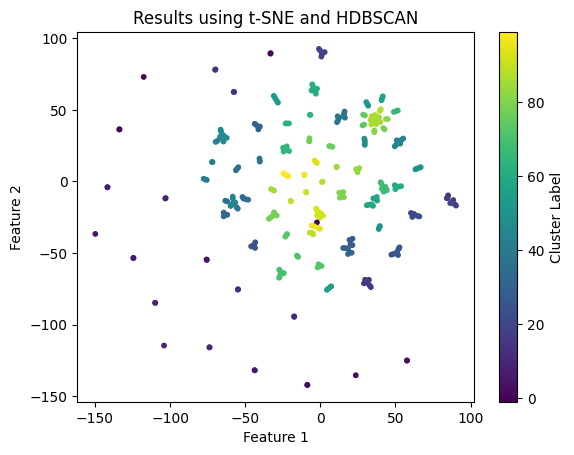

Distancia promedio: 83.52395629882812
Distancia mínima: 0.3482244312763214
Distancia máxima: 264.5120849609375
Silhouette Score: 0.6999763250350952


In [48]:
tsne = TSNE(n_components=2, perplexity=1, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# cluster_selection_epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5, 3]
# min_cluster_size_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# min_samples_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# silhouette_scores = []

# for epsilon in cluster_selection_epsilon_values:
#     for min_cluster_size in min_cluster_size_values:
#         for min_samples in min_samples_values:
#             clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=epsilon)
#             cluster_labels = clusterer.fit_predict(embeddings_2d)
#             score = silhouette_score(embeddings_2d, cluster_labels)
#             silhouette_scores.append({"score": score, "epsilon": epsilon, "min_cluster_size": min_cluster_size, "min_samples": min_samples})

# silhouette_scores = pd.DataFrame(silhouette_scores)
# silhouette_scores = silhouette_scores.sort_values(by='score', ascending=False)
# print(silhouette_scores.head(1)) # Best silhouette score: 0.696662, epsilon: 0.1, min_cluster_size: 2, min_samples: 1 

cluster_labels = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_epsilon=0.6).fit_predict(embeddings_2d)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('Results using t-SNE and HDBSCAN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

distances = pairwise_distances(embeddings_2d, metric='euclidean')
average_distance = np.mean(distances)
min_distance = np.min(distances[distances > 0])
max_distance = np.max(distances)

print(f"Distancia promedio: {average_distance}")
print(f"Distancia mínima: {min_distance}")
print(f"Distancia máxima: {max_distance}")

score = silhouette_score(embeddings_2d, cluster_labels)
print(f"Silhouette Score: {score}")

BERT

- Distancia promedio: 88.40070343017578
- Distancia mínima: 0.47465968132019043
- Distancia máxima: 276.6690979003906
- Silhouette Score: 0.6445894241333008

RoBERTa

- Distancia promedio: 83.52395629882812
- Distancia mínima: 0.3482244312763214
- Distancia máxima: 264.5120849609375
- Silhouette Score: 0.6999763250350952


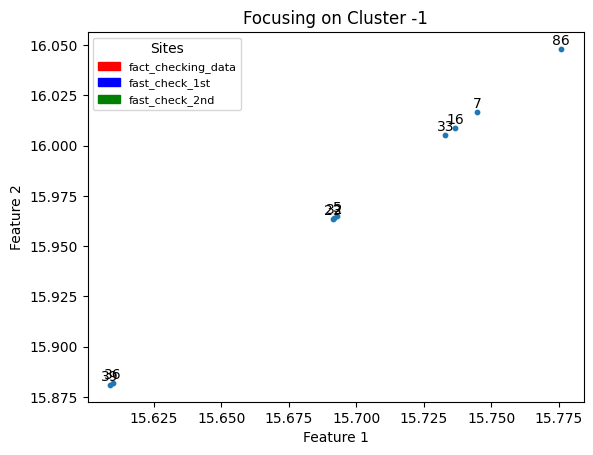

In [63]:
colors = {'fact_checking_data': 'red', 'fast_check_1st': 'blue', 'fast_check_2nd': 'green'}

cluster_to_print = -1
facts_selected = []
facts_labels = []

for index, fact in enumerate(embeddings_2d):
    if cluster_labels[index] == cluster_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)

plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], s=10)
for x, y, etiqueta in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')

legend_labels = [mpatches.Patch(color=color, label=label) for label, color in colors.items()]
plt.legend(handles=legend_labels, title="Sites", fontsize=8)
plt.title(f'Focusing on Cluster {cluster_to_print}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## 2.5. UMAP 2D Visualization


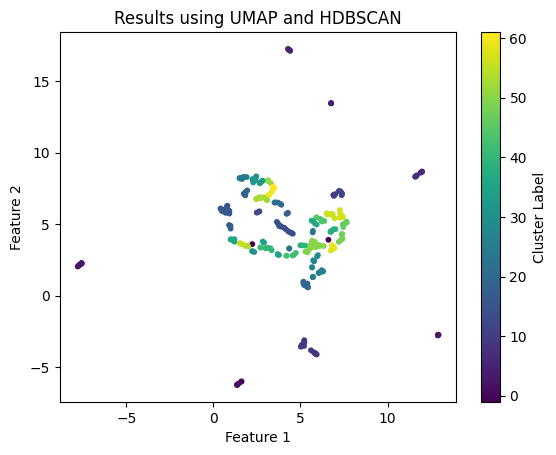

Distancia promedio: 5.941552639007568
Distancia mínima: 2.4616068913019262e-05
Distancia máxima: 23.637327194213867
Silhouette Score: 0.672860324382782


In [146]:
umap_model = umap.UMAP(n_components=2, random_state=12, n_neighbors=3, min_dist=0.0, n_jobs=1, init='random')
embeddings_2d = umap_model.fit_transform(embeddings)

# cluster_selection_epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5, 3]
# min_cluster_size_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# min_samples_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# silhouette_scores = []
# for epsilon in cluster_selection_epsilon_values:
#     for min_cluster_size in min_cluster_size_values:
#         for min_samples in min_samples_values:
#             clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=epsilon)
#             cluster_labels = clusterer.fit_predict(embeddings_2d)
#             score = silhouette_score(embeddings_2d, cluster_labels)
#             silhouette_scores.append({"score": score, "epsilon": epsilon, "min_cluster_size": min_cluster_size, "min_samples": min_samples})
# silhouette_scores = pd.DataFrame(silhouette_scores)
# silhouette_scores = silhouette_scores.sort_values(by='score', ascending=False)
# print(silhouette_scores.head(1))

cluster_labels = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_epsilon=0.2).fit_predict(embeddings_2d)

# Visualizar los resultados
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, s=10)
plt.title('Results using UMAP and HDBSCAN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

distances = pairwise_distances(embeddings_2d, metric='euclidean')
average_distance = np.mean(distances)
min_distance = np.min(distances[distances > 0])  
max_distance = np.max(distances)
print(f"Distancia promedio: {average_distance}")
print(f"Distancia mínima: {min_distance}")
print(f"Distancia máxima: {max_distance}")

# Evaluar la calidad del clustering
score = silhouette_score(embeddings_2d, cluster_labels)
print(f"Silhouette Score: {score}")

pages_embeddings_info =[]
for index, emb in enumerate(embeddings_2d):
    pages_embeddings_info.append(embedding_data.emb_data(emb, index, row_data["pages"][index], cluster_labels[index]))


BERT

- Distancia promedio: 7.3546671867370605
- Distancia mínima: 0.0007768553914502263
- Distancia máxima: 25.34515953063965
- Silhouette Score: 0.6593766808509827

RoBERTa

- Distancia promedio: 5.941552639007568
- Distancia mínima: 2.4616068913019262e-05
- Distancia máxima: 23.637327194213867
- Silhouette Score: 0.672860324382782


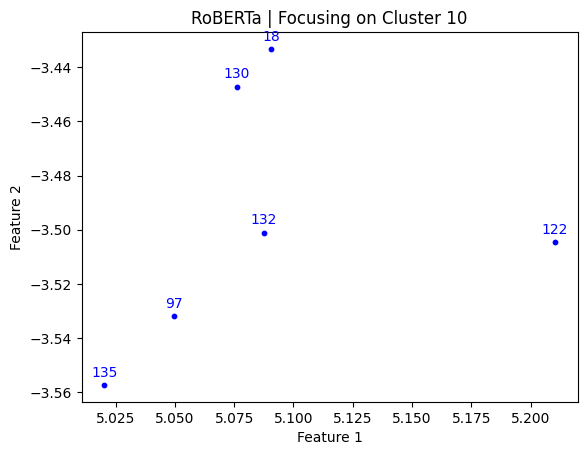

18 - https://www.fastcheck.cl/2021/07/26/yasna-provoste-fue-inhabilitada-durante-5-anos-para-ejercer-cargos-publicos-luego-de-robar-600-millones-de-dolares-enganoso/
97 - https://factchecking.cl/user-review/kast-lidero-el-grupo-que-acuso-constitucionalmente-a-la-candidata-presidencial-yasna-provoste-cuando-era-ministra-de-educacion/
122 - https://factchecking.cl/user-review/sebastian-pinera-si-recibe-su-dieta-vitalicia-como-ex-presidente/
130 - https://factchecking.cl/user-review/matias-perez-cruz-aporto-dos-millones-a-kast-para-las-presidenciales-del-2017/
132 - https://factchecking.cl/user-review/parisi-exagera-el-sueldo-y-dieta-parlamentaria-de-provoste/
135 - https://factchecking.cl/user-review/el-diputado-boric-no-esta-obligado-a-participar-de-la-discusion-sobre-los-presupuestos-de-cultura/


In [150]:
colors = {'fact_checking_data': 'red', 'fast_check_1st': 'blue', 'fast_check_2nd': 'green'}

cluster_to_print = 10
embeddings_selected = []
facts_labels = []
for index, emb in enumerate(pages_embeddings_info):
    if emb.get_cluster() == cluster_to_print:
        embeddings_selected.append(emb)

# plt.scatter([fact.get_embedding()[0] for fact in embeddings_selected], [fact.get_embedding()[1] for fact in embeddings_selected], s=10)

colors = ['red', 'blue', 'green']

# reference_data = [fact[0] for fact in facts_selected]
for emb, etiqueta in zip([emb.get_embedding() for emb in embeddings_selected], [emb.get_label() for emb in embeddings_selected]):
    x = emb[0]
    y = emb[1]
    # reference = 0
    # times = 0
    # for index, cordx in enumerate(reference_data):
    #     if cordx == x:
    #         continue
    #     diff = abs(cordx - x)
    #     if diff < 0.1:
    #         reference += 7
    #         times += 1
    #         del reference_data[index]

    # if times >= 3:
    #     times = int(times/3)
    #     if times >= 3:
    #         times = 2
    plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0, 6), ha='center', color="blue")
    plt.scatter(x, y, s=10, color="blue")

# legend_labels = [mpatches.Patch(color=color, label=label) for label, color in colors.items()]
# plt.legend(handles=legend_labels, title="Sites", fontsize=8)

plt.title(f'RoBERTa | Focusing on Cluster {cluster_to_print}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# plt.xlim(13.8, 14.8)
# plt.ylim(1.25, 2.75)
plt.show()

for emb in embeddings_selected:
    print(f"{emb.get_label()} - {emb.get_page()['link']}")
        

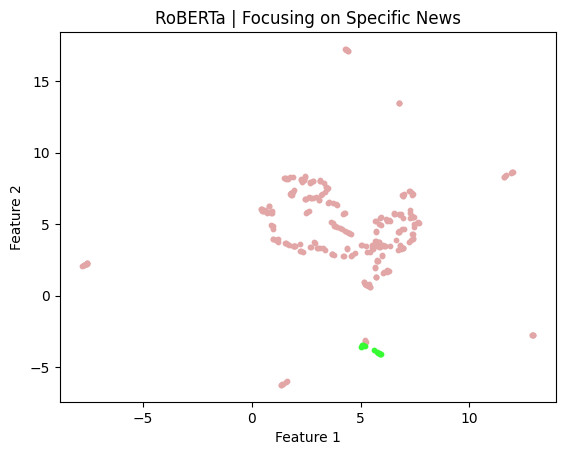

[0] link: https://www.fastcheck.cl/2022/05/25/la-palabra-indigena-esta-124-veces-en-el-borrador-de-la-nueva-constitucion-la-palabra-chileno-solo-37-veces-falso/
[1] link: https://www.fastcheck.cl/2022/05/13/convencion-aprueba-prohibir-el-uso-de-armas-de-fuego-a-carabineros-de-chile-falso/
[2] link: https://www.fastcheck.cl/2022/07/13/la-propuesta-de-nueva-constitucion-le-permitira-a-evo-morales-establecer-a-traves-de-la-plurinacionalidad-con-autonomia-y-autogobierno-la-independencia-o-anexion-de-algun-territorio-declarado-de/
[3] link: https://www.fastcheck.cl/2022/09/09/imagen-a-espaldas-de-la-ciudadania-cambiaron-el-articulo-142-de-la-constitucion-enganoso/
[4] link: https://www.fastcheck.cl/2022/08/11/articulo-67-4-restringe-la-libertad-religiosa-y-de-predicacion-falso/
[5] link: https://www.fastcheck.cl/2022/05/17/video-maduro-celebra-y-manda-un-saludo-a-la-convencion-por-la-entrega-del-borrador-pluri-constituyente-enganoso/
[6] link: https://www.fastcheck.cl/2021/10/25/en-la-pract

In [147]:
fact_index = [18, 61, 97, 122, 130, 132, 135, 137, 144, 146, 153, 158, 166]

facts_selected = []
facts_labels = []
color_index = []
for index in range(len(embeddings_2d)):
    facts_labels.append(index)
    if index in fact_index:
        # facts_selected.append(embeddings_2d[index].tolist())
        color_index.append(2)
        continue
    color_index.append(0)
    
colors = ['#e2a6a6', '#3e63ef', '#36fa32']

reference_data = [fact[0] for fact in facts_selected]
plot_index = 0
for x, y, etiqueta in zip([fact[0] for fact in embeddings_2d], [fact[1] for fact in embeddings_2d], facts_labels):
    # reference = 0
    # times = 0
    # for index, cordx in enumerate(reference_data):
    #     if cordx == x:
    #         continue
    #     diff = abs(cordx - x)
    #     if diff < 0.1:
    #         reference += 7
    #         times += 1
    #         del reference_data[index]

    # if times >= 3:
    #     times = int(times/3)
    #     if times >= 3:
    #         times = 2
    # plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0, 6 + reference), ha='center', color=colors[color_index[plot_index]])
    plt.scatter(x, y, s=10, c=colors[color_index[plot_index]], zorder=color_index[plot_index])
    plot_index += 1

# legend_labels = [mpatches.Patch(color=color, label=label) for label, color in colors.items()]
# plt.legend(handles=legend_labels, title="Sites", fontsize=8)

plt.title(f'RoBERTa | Focusing on Specific News')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

for index, page in enumerate(row_data["pages"]):
    if index in facts_labels:
        print(f"[{index}] link: {page['link']}")

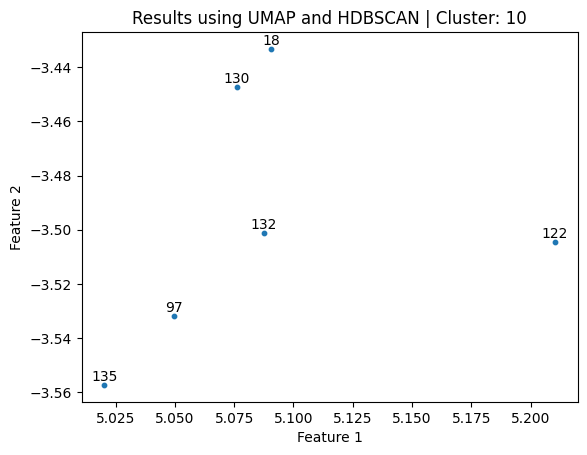

18 - https://www.fastcheck.cl/2021/07/26/yasna-provoste-fue-inhabilitada-durante-5-anos-para-ejercer-cargos-publicos-luego-de-robar-600-millones-de-dolares-enganoso/
97 - https://factchecking.cl/user-review/kast-lidero-el-grupo-que-acuso-constitucionalmente-a-la-candidata-presidencial-yasna-provoste-cuando-era-ministra-de-educacion/
122 - https://factchecking.cl/user-review/sebastian-pinera-si-recibe-su-dieta-vitalicia-como-ex-presidente/
130 - https://factchecking.cl/user-review/matias-perez-cruz-aporto-dos-millones-a-kast-para-las-presidenciales-del-2017/
132 - https://factchecking.cl/user-review/parisi-exagera-el-sueldo-y-dieta-parlamentaria-de-provoste/
135 - https://factchecking.cl/user-review/el-diputado-boric-no-esta-obligado-a-participar-de-la-discusion-sobre-los-presupuestos-de-cultura/


In [149]:
page_inndex = 18

# Busca el cluster al que pertenece la noticia seleccionada
cluster_to_print = 0
for emb in pages_embeddings_info:
    if emb.get_label() == page_inndex:
        cluster_to_print = emb.get_cluster()
        break

#Adquiere las noticias según el cluster
embeddings_to_show = []
pages_labels = []
for emb in pages_embeddings_info:
    if emb.get_cluster() == cluster_to_print:
        embeddings_to_show.append(emb)
        pages_labels.append(emb.get_label())

# Visualizar los resultados
plt.scatter([emb.get_embedding()[0] for emb in embeddings_to_show], [emb.get_embedding()[1] for emb in embeddings_to_show], s=10)

for x, y, etiqueta in zip([emb.get_embedding()[0] for emb in embeddings_to_show], [emb.get_embedding()[1] for emb in embeddings_to_show], pages_labels):
    plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')

plt.title(f'Results using UMAP and HDBSCAN | Cluster: {cluster_to_print}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

for emb in embeddings_to_show:
    print(f"{emb.get_label()} - {emb.get_page()['link']}")

In [81]:
links = ["https://www.fastcheck.cl/2021/07/26/yasna-provoste-fue-inhabilitada-durante-5-anos-para-ejercer-cargos-publicos-luego-de-robar-600-millones-de-dolares-enganoso/",
         "https://factchecking.cl/user-review/bajo-la-propuesta-de-constitucion-no-seria-inconstitucional-que-el-1-del-pais-posea-la-mitad-del-pib-del-pais/",
         "https://factchecking.cl/user-review/kast-lidero-el-grupo-que-acuso-constitucionalmente-a-la-candidata-presidencial-yasna-provoste-cuando-era-ministra-de-educacion/",
         "https://factchecking.cl/user-review/sebastian-pinera-si-recibe-su-dieta-vitalicia-como-ex-presidente/",
         "https://factchecking.cl/user-review/matias-perez-cruz-aporto-dos-millones-a-kast-para-las-presidenciales-del-2017/",
         "https://factchecking.cl/user-review/parisi-exagera-el-sueldo-y-dieta-parlamentaria-de-provoste/",
         "https://factchecking.cl/user-review/el-diputado-boric-no-esta-obligado-a-participar-de-la-discusion-sobre-los-presupuestos-de-cultura/",
         "https://factchecking.cl/user-review/la-gran-mineria-privada-aporto-al-fisco-10-veces-mas-de-lo-planteado-por-eduardo-artes/",
         "https://factchecking.cl/user-review/las-acciones-del-banco-central-ayudaron-a-mantener-la-estabilidad-financiera-durante-la-crisis-economica/",
         "https://factchecking.cl/user-review/el-97-de-los-proveedores-del-estado-son-micro-pequenas-y-medianas-empresas/",
         "https://factchecking.cl/user-review/viral-de-tiktok-sobre-las-afp-plantea-datos-correctos-pero-su-interpretacion-es-imprecisa/",
         "https://factchecking.cl/user-review/la-rentabilidad-de-los-fondos-de-pensiones-aumento-luego-del-retiro-del-10-debido-a-diferentes-factores/",
         "https://factchecking.cl/user-review/un-checklist-sobre-la-economia-nacional/"
         ]

indeces = []

for emb in pages_embeddings_info:
  if emb.get_page()["link"] in links:
    print(f"{emb.get_label()} - {emb.get_page()['link']}")
    indeces.append(emb.get_label())

print(indeces)

18 - https://www.fastcheck.cl/2021/07/26/yasna-provoste-fue-inhabilitada-durante-5-anos-para-ejercer-cargos-publicos-luego-de-robar-600-millones-de-dolares-enganoso/
61 - https://factchecking.cl/user-review/bajo-la-propuesta-de-constitucion-no-seria-inconstitucional-que-el-1-del-pais-posea-la-mitad-del-pib-del-pais/
97 - https://factchecking.cl/user-review/kast-lidero-el-grupo-que-acuso-constitucionalmente-a-la-candidata-presidencial-yasna-provoste-cuando-era-ministra-de-educacion/
122 - https://factchecking.cl/user-review/sebastian-pinera-si-recibe-su-dieta-vitalicia-como-ex-presidente/
130 - https://factchecking.cl/user-review/matias-perez-cruz-aporto-dos-millones-a-kast-para-las-presidenciales-del-2017/
132 - https://factchecking.cl/user-review/parisi-exagera-el-sueldo-y-dieta-parlamentaria-de-provoste/
135 - https://factchecking.cl/user-review/el-diputado-boric-no-esta-obligado-a-participar-de-la-discusion-sobre-los-presupuestos-de-cultura/
137 - https://factchecking.cl/user-review